In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
def get_column(df, column:str) -> pd.Series:
    assert column != ''
    assert df[column] is not None
    
    if type(df) == pd.DataFrame:
        return df[column]
    elif type(df) == dd.core.DataFrame: 
        return df[column].compute()
    
    raise Exception('Datatype not supported yet')
    
def get_column_value_counts(s) -> pd.Series:
    
    assert s is not None
    
    if type(s) == pd.Series:
        return s.value_counts()
    elif type(s) == dd.core.Series: 
        return s.value_counts().compute()
    
    raise Exception('Datatype not supported yet')
    

def scatter_columns(
    df, 
    col_x:str, 
    col_y:str, 
    col_z:str, 
    tail:bool=False, 
    xticks:np.ndarray=np.ndarray((0,0)), 
    yticks:np.ndarray=np.ndarray((0,0)),
    figsize:tuple=(20,25),
    count:int=5
) -> None:
    
    assert col_x != ''
    assert col_y != ''
    assert col_z != ''
    
    assert df[col_x] is not None
    assert df[col_y] is not None
    assert df[col_z] is not None
    
    plt.rcParams["figure.figsize"] = figsize
    
    counts = get_column_value_counts(df[col_z])
    
    print('value counts stats', {'max':counts.max(),'mean':counts.mean(),'median':counts.median(),'std':counts.std(),'min':counts.min()})
    
    if tail:
        keys = counts.tail(count).keys()
    else:    
        keys = counts.head(count).keys()
    
    colors = mpl.cm.rainbow(np.linspace(0, 1, len(keys)))

    for i, value in enumerate(tqdm(keys)):
        
        computed = df[df[col_z] == value].groupby([col_x])[col_y].mean().reset_index().compute().sort_values(by=col_x)
        
        x = get_column(computed, col_x)
        y = get_column(computed, col_y)
        
        plt.scatter(x, y, linewidths=True, label=f'{col_z}:{value}', edgecolors=colors[i])
        plt.plot(x, y, linestyle='dashed', color='gray')
        
    if xticks.any():
        plt.xticks(xticks)
        
    if yticks.any():
        plt.yticks(yticks)
    
    plt.legend() # keys.astype(np.int)
    plt.show()
    
# code to save checkpoint

def save_checkpoint(ddf:dd.core.DataFrame, config_year:dict):
    
    path_to_file = f'{config_year.path}/{config_year.year}/{config_year.dataset}'
    
    os.system(f"mkdir -p {path_to_file}")

    ddf.to_csv(f'{path_to_file}/{config_year.year}_{config_year.dataset}_*.csv')
    
    print('checkpoint saved.')
    
    
def load_checkpoint(config_year:dict) -> dd.core.DataFrame:
    
    path_files_21 = f'{config_21.path}/{config_21.year}/{config_21.dataset}'

    if os.path.exists(f'{path_files_21}/{config_21.year}_{config_21.dataset}_00.csv'):

        ddf = dd.read_csv(
            f'{path_files_21}/{config_21.year}_{config_21.dataset}_*.csv', 
            dtype={
                'dayofmonth_last_updated_date': 'int64',
                'dayofweek_last_updated_date': 'int64',
                'dayofyear_last_updated_date': 'int64',
                'hour_last_updated_date': 'int64',
                'is_charging_station': 'int64',
                'is_installed': 'int64',
                'is_renting': 'int64',
                'is_returning': 'int64',
                'last_reported': 'int64',
                'last_updated': 'int64',
                'month_last_updated_date': 'int64',
                'station_id': 'int64',
                'status': 'int64',
                'year_last_updated_date': 'int64'
            }
        )

        print('checkpoint reloaded.')
    
        return ddf
    else:
        raise Exception('Files not found.')

In [3]:
def Cov(X, Y): 
    def _get_dvis(V):
        return [v - np.mean(V) for v in V]
    dxis = _get_dvis(X)
    dyis = _get_dvis(Y)
    return np.sum([x * y for x, y in zip(dxis, dyis)])/len(X)

def PearsonCorr(X, Y):
    assert len(X) == len(Y)
    return Cov(X, Y) / np.prod([np.std(V) for V in [X, Y]])

def list2rank(l):
    #l is a list of numbers
    # returns a list of 1-based index; mean when multiple instances
    return [np.mean([i+1 for i, sorted_el in enumerate(sorted(l)) if sorted_el == el]) for el in l]

def spearmanRank(X, Y):
    # X and Y are same-length lists
    return PearsonCorr(list2rank(X), list2rank(Y))



In [4]:
config = pd.Series({
    'path':'../dades',
    'file_type':'csv',
    'years':[2021],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [5]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:44525 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [6]:
data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

# 2021 

In [7]:
config_21 = pd.Series({
    'path':'../dades',
    'file_type':'csv',
    'year':2021,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [8]:
first_size = get_ddf_shape(data[2021])

## Preprocessing

In [9]:
data[2021] = load_checkpoint(config_21)

# checkpoint reloaded.

checkpoint reloaded.


In [10]:
last_size = get_ddf_shape(data[2021])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(first_size[0]-last_size[0]):02d} rows')
print(f'dropped {(first_size[0]-last_size[0]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 02 rows
dropped 02 columns


In [11]:
len(data[2021].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [12]:
nans = get_features_nans(data[2021])

zeros = get_features_zero(data[2021])

In [13]:
nans

{}

In [14]:
zeros

{'Unnamed: 0': 0.0002720099700721031,
 'num_bikes_available': 3.179841885137897,
 'num_bikes_available_types.mechanical': 13.69506730320022,
 'num_bikes_available_types.ebike': 24.63465094207253,
 'num_docks_available': 0.818568669936982,
 'status': 99.94392061117013,
 'is_installed': 0.0016320598204326183,
 'is_renting': 0.061406250743777265,
 'is_returning': 0.061406250743777265,
 'dayofweek_last_updated_date': 14.131937982633524,
 'hour_last_updated_date': 4.122583106412794}

In [15]:
# nuniques = get_columns_nunique(data[2021])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# last_updated                               8700
# year_last_updated_date                        2
# month_last_updated_date                      12
# week_last_updated_date                       53
# dayofweek_last_updated_date                   7
# dayofmonth_last_updated_date                 31
# dayofyear_last_updated_date                 366
# hour_last_updated_date                       24
# traffic                                    1741
# dtype: int64

uniques = get_columns_unique(data[2021])

In [16]:
uniques

{'Unnamed: 0': 0              0
 1              1
 2              2
 3              3
 4              4
            ...  
 377400    377400
 377401    377401
 377402    377402
 377403    377403
 377404    377404
 Name: Unnamed: 0, Length: 377405, dtype: int64,
 'station_id': 0        1
 1      271
 2      400
 3      510
 4       26
       ... 
 504     79
 505    168
 506     91
 507    467
 508     52
 Name: station_id, Length: 509, dtype: int64,
 'num_bikes_available': 0       43.000000
 1       40.666667
 2       41.000000
 3       42.636364
 4       44.625000
           ...    
 5393    13.305556
 5394    18.035714
 5395    17.527778
 5396     1.058824
 5397    19.595238
 Name: num_bikes_available, Length: 5398, dtype: float64,
 'num_bikes_available_types.mechanical': 0       43.000000
 1       40.666667
 2       41.000000
 3       41.909091
 4       43.625000
           ...    
 4935     1.107143
 4936    16.972222
 4937    16.409091
 4938     1.117647
 4939     7.464286
 Name: n

## 2021 station_id

In [17]:
print(stats.describe(data[2021].station_id))
data[2021].station_id.describe().compute()

DescribeResult(nobs=4411603, minmax=(1, 519), mean=261.3322660719924, variance=22296.133432198276, skewness=-0.010855060248476238, kurtosis=-1.187342110659017)


count    4.411603e+06
mean     2.613323e+02
std      1.493189e+02
min      1.000000e+00
25%      1.330000e+02
50%      2.630000e+02
75%      3.900000e+02
max      5.190000e+02
Name: station_id, dtype: float64

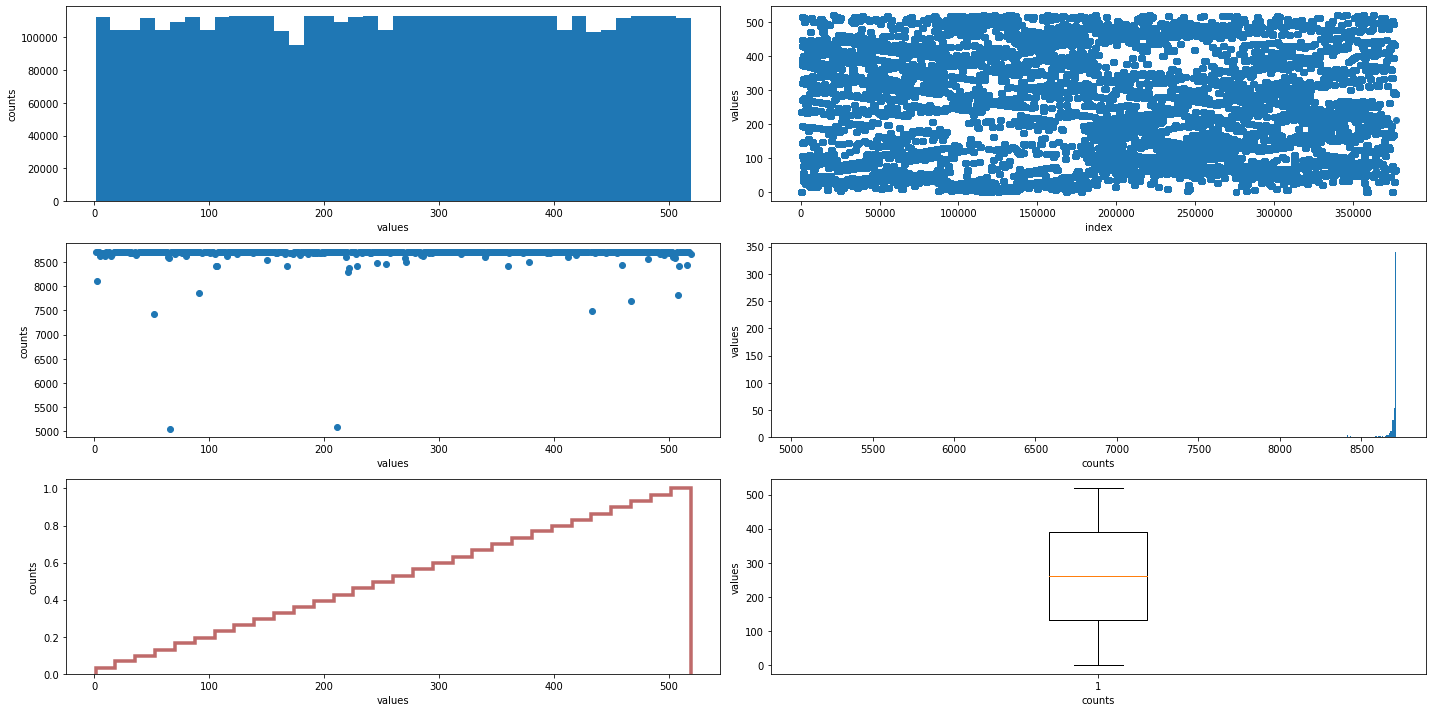

In [18]:
show_counts(data[2021].station_id.compute())

value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

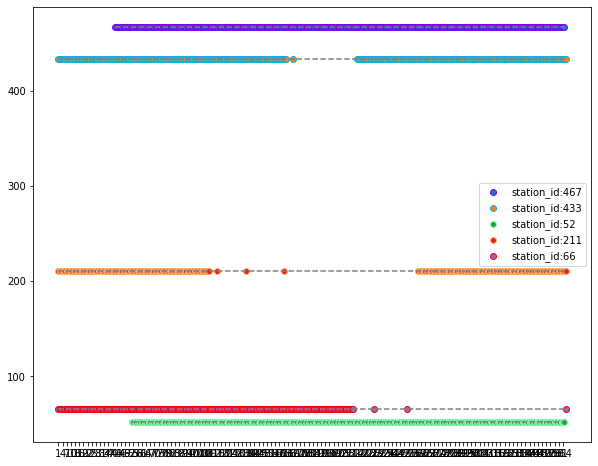

CPU times: user 2.26 s, sys: 714 µs, total: 2.26 s
Wall time: 8.66 s


In [19]:
%%time

scatter_columns(
    data[2021], 
    'dayofyear_last_updated_date', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear_last_updated_date'].min(),uniques['dayofyear_last_updated_date'].max(), 3.0),
    figsize=(10,8)
)


## 2021 num_bikes_available

In [20]:
print(stats.describe(data[2021].num_bikes_available))
data[2021].num_bikes_available.describe().compute()

DescribeResult(nobs=4411603, minmax=(0.0, 54.0), mean=9.728862347869377, variance=65.75362055240853, skewness=0.9545646752665524, kurtosis=0.7743120895645914)


count    4.411603e+06
mean     9.728862e+00
std      8.108861e+00
min      0.000000e+00
25%      4.700000e+00
50%      1.000000e+01
75%      1.622222e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

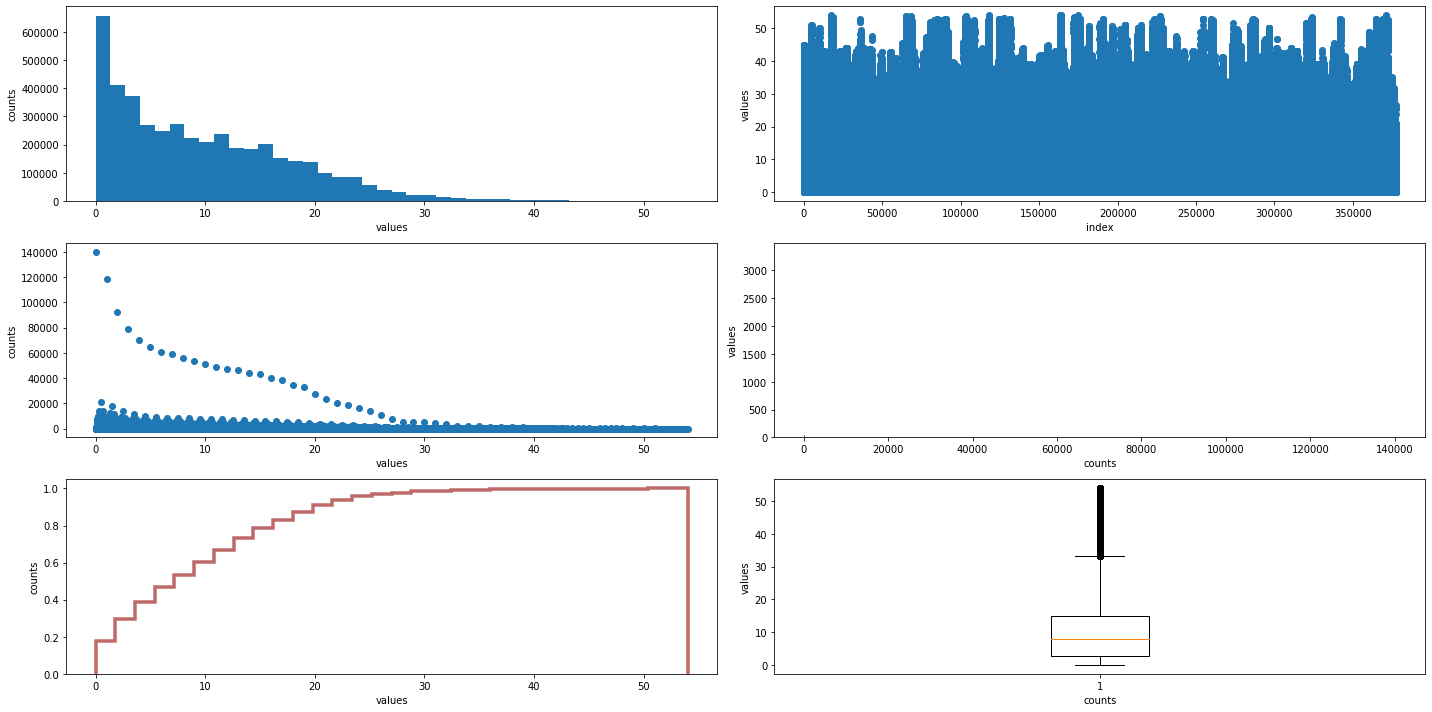

In [21]:
show_counts(data[2021].num_bikes_available.compute())

348
value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

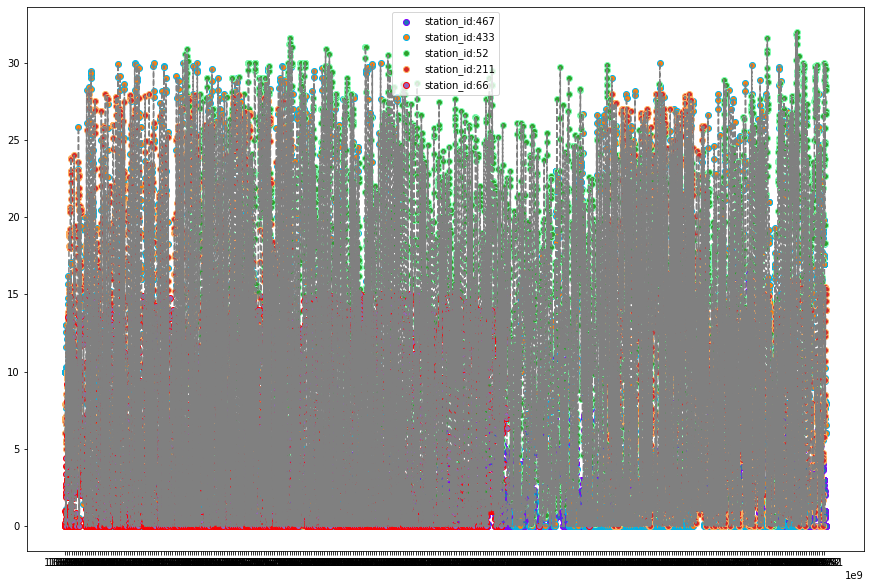

CPU times: user 5.03 s, sys: 443 ms, total: 5.47 s
Wall time: 11.8 s


In [22]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['last_updated'][i] for i, x in enumerate(uniques['last_updated']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[2021], 
    'last_updated', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

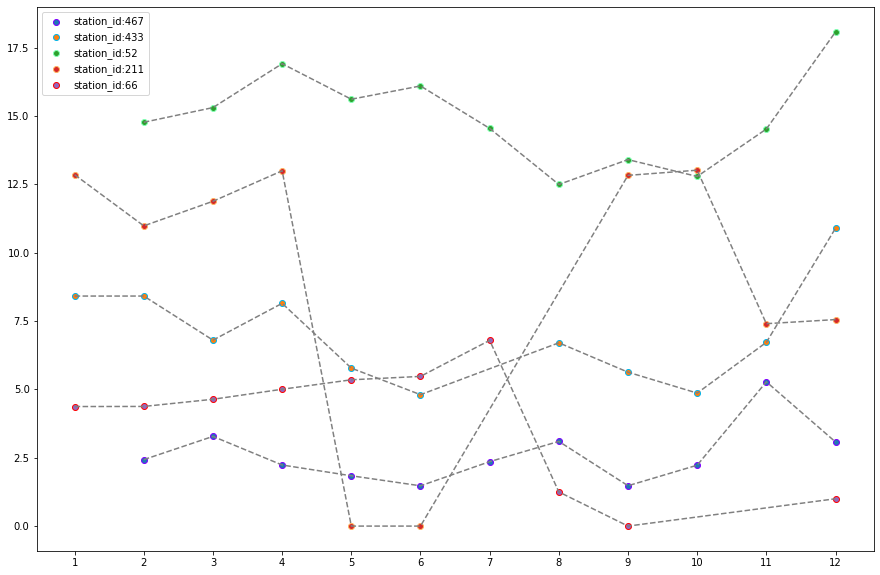

CPU times: user 1.25 s, sys: 106 ms, total: 1.35 s
Wall time: 7.95 s


In [23]:
%%time

scatter_columns(
    data[2021], 
    'month_last_updated_date', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month_last_updated_date']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

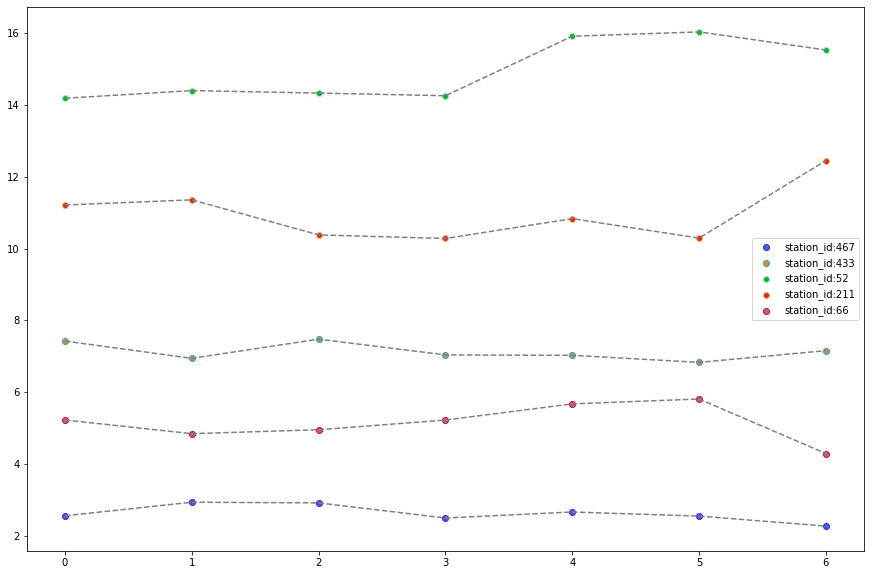

CPU times: user 1.35 s, sys: 13 ms, total: 1.37 s
Wall time: 7.76 s


In [24]:
%%time

scatter_columns(
    data[2021], 
    'dayofweek_last_updated_date', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek_last_updated_date']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

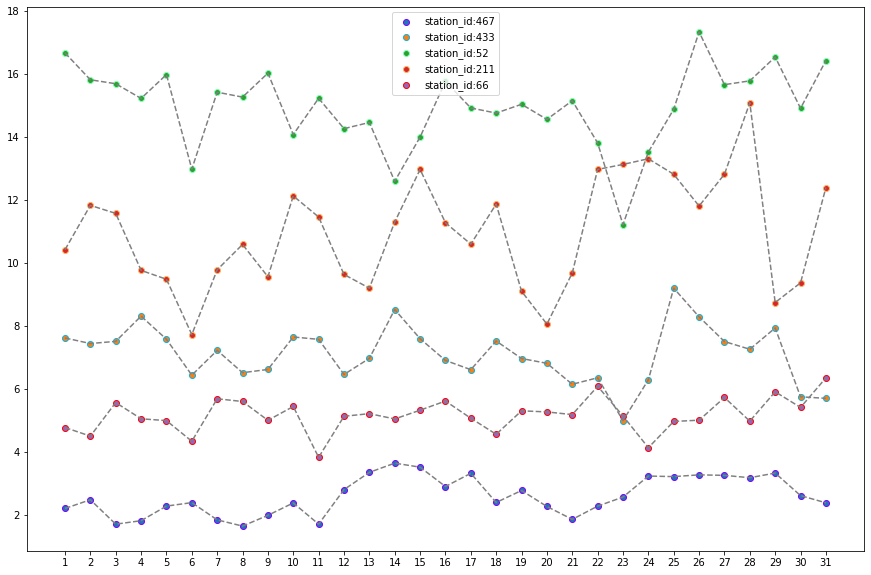

CPU times: user 1.36 s, sys: 133 ms, total: 1.5 s
Wall time: 7.72 s


In [25]:
%%time

scatter_columns(data[2021], 'dayofmonth_last_updated_date', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofmonth_last_updated_date']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

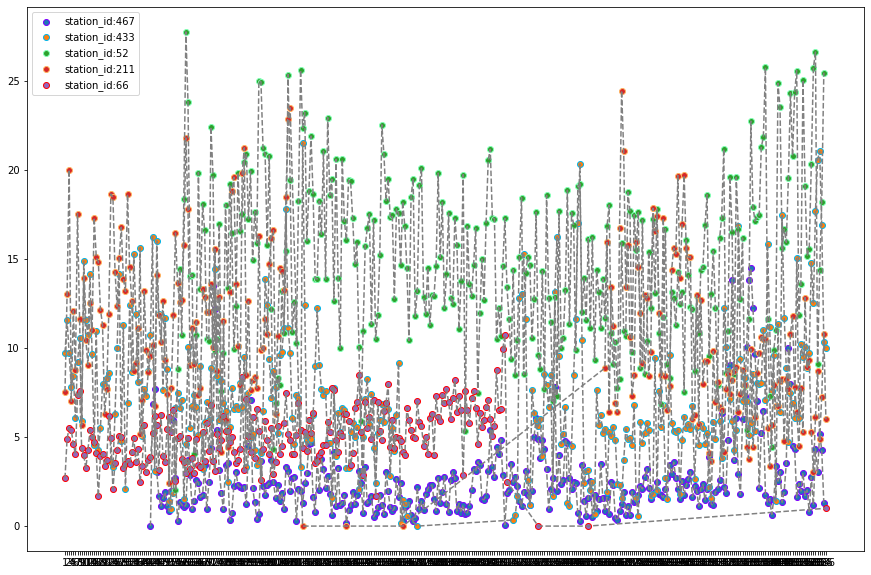

CPU times: user 3.94 s, sys: 346 ms, total: 4.28 s
Wall time: 10.7 s


In [26]:
%%time

scatter_columns(data[2021], 'dayofyear_last_updated_date', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear_last_updated_date']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8711, 'mean': 8667.196463654223, 'median': 8709.0, 'std': 255.18987972072696, 'min': 5060}


  0%|          | 0/5 [00:00<?, ?it/s]

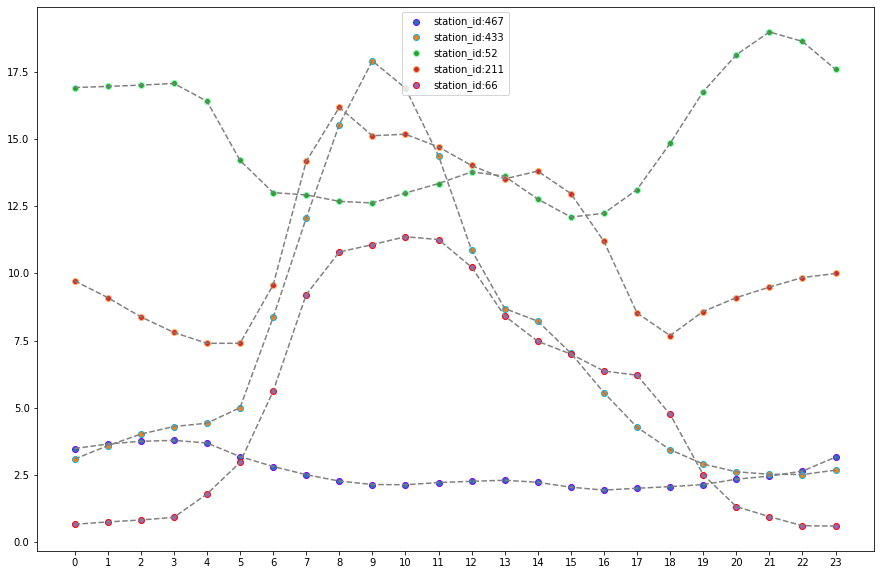

CPU times: user 1.32 s, sys: 1.41 ms, total: 1.33 s
Wall time: 7.79 s


In [27]:
%%time

scatter_columns(data[2021], 'hour_last_updated_date', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour_last_updated_date']),
    figsize=(15,10),
    count=5
)

24
value counts stats {'max': 24, 'mean': 23.93452380952381, 'median': 24.0, 'std': 1.0764414587629505, 'min': 3}


  0%|          | 0/5 [00:00<?, ?it/s]

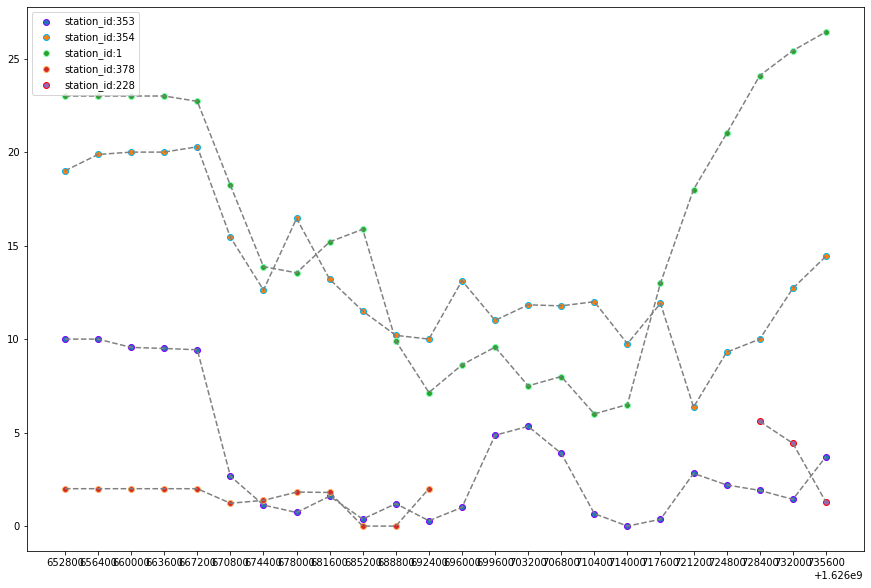

CPU times: user 1.42 s, sys: 114 ms, total: 1.53 s
Wall time: 9.22 s


In [30]:
%%time

day_of_interest = 200
data_of_interest = data[2021][data[2021].dayofyear_last_updated_date == day_of_interest]


# Checking availibilty for docks one day
xtikcs_scatter = data_of_interest.last_updated.unique().compute() # .astype(int)
print(len(xtikcs_scatter))

scatter_columns(
    data_of_interest, 
    'last_updated', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)
